### Вводное слово

Данные, которые используются в данном проекте, были получены из объявлений о продаже квартир вторичного рынка жилья Москвы с онлайн-портала по продаже недвижимости ЦИАН. Все собранные объявления были опубликованы 18-31 декабря 2020 года. В выборку вошли только стандартные 1,2 и 3-х комнатные квартиры вторичного рынка жилья (без пентхаусов и апартаментов). Сбор объявлений осуществлялся с помощью технологии веб-скрейпинга через библиотеки request и BeautifulSoup (код парсера и сбора данных не приводится по юридическим соображениям).

Далее полученные данные были смэтчины с данными портала "Реформа ЖКХ". Благодаря такому мэтчингу были получены дополнительные переменные, а также было осуществлено заполнение пропусков. Мэтчинг баз данных осуществлялся по адресу дома с помощью разработанного для этой цели алгоритма.

Наконец была проведена вся необходимая предобработка данных:
* очистка данных от неадекватных значений по полям;
* удаление выбросов по таргету (под выбросами понимались уникальные предложения или те, где была явно допущена ошибка при заполнении);
* удаление дублей (у тех, кто размещает объявления о продаже, есть стимулы к дубликации объявлений).

В данном ноутбуке происходит знакомство с уже обработанными данными, их предварительный анализ и проверка на наличие в них проблем. В конце осуществляется разбиение исходной выборки на train и out-of-sample, которые в дальнейшем будут непосредственно использоваться для построения моделей и проверки их качества.

### Подготовка к работе

###### Импорт библиотек

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split

###### Настройка путей и загрузка данных

In [2]:
PATH = os.path.abspath(os.curdir)
PATH_DATA = PATH + '\\Data\\'

In [3]:
data_market = pd.read_csv(PATH_DATA + 'data_december_2021.csv')
data_map = gpd.read_file(PATH_DATA + 'Moskow_8.geojson')

###### Настройка наименований и описание полей

In [4]:
data_market['price/m2'] = data_market['price'] / data_market['square_total']

target = 'price/m2'

features_full = ['rooms', 'lat', 'lng', 'square_total', 'square_living',
       'square_kitchen', 'ceiling', 'renovation', 'view',
       'type_house', 'floor_type', 'built_year', 'energy_efficiency',
       'playground', 'sportsground', 'foundation_type', 'electrical_type',
       'electrical_entries_count', 'heating_type', 'hot_water_type',
       'gas_type', 'ventilation_type',
       'firefighting_type', 'drainage_type', 'floor_flat', 'floor_house']

В качестве таргета планируется использовать цену за квадратный метр. Остальные имеющиеся поля планируется использовать в качестве потенциальных фичей. 

**Расшифровка колонок следующая:**
* price - цена квартиры;
* rooms - количество комнат;
* lat - широта;
* lng - долгота;
* square_total - общая площадь;
* square_living - жилая площадь;
* square_kitchen - площадь кухни;
* ceiling - высота потолков;
* renovation - ремонт в квартире;
* view - вид из окон;
* type_house - технология строительства дома;
* floor_type - тип перекрытий в доме;
* built_year - год постройки;
* energy_efficiency - класс энергетической эффективности;
* playground - наличие детской площадки;
* sportsground - наличие спортивной площадки;
* foundation_type - тип фундамента;
* electrical_type - тип системы электроснабжения;
* electrical_entries_count - количество вводов в МКД;
* heating_type - тип системы теплоснабжения;
* hot_water_type - тип системы горячего водоснабжения;
* gas_type - тип системы газоснабжения;
* ventilation_type - тип системы вентиляции;
* firefighting_type - тип системы пожаротушения;
* drainage_type - тип системы водостоков;
* floor_flat - этаж квартиры;
* floor_house - количество этажей в доме.


### Статистический анализ таргета

###### Описательные статистики таргета

Знакомство с данными начнем с таргета (стоимости квадратного метра). Но поскольку в выборке присутствуют квартиры с различным количеством комнат, было бы полезно предварительно посмотреть на соотношения квартир того или иного типа.

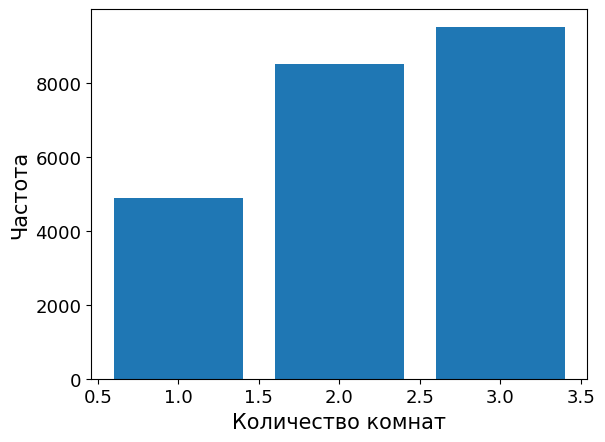

In [5]:
plt.bar(list(Counter(data_market['rooms']).keys()), list(Counter(data_market['rooms']).values()))
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Частота', fontsize = 15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

Больше всего 3-комнатных квартир (около 10 000). Далее идут 2-комнатные (около 8 500) и 1-комнатные (около 5 000). Из-за такого разного баланса имеет смысл рассматривать описательные статистики в разрезе количества комнат.

Посмотрим, какое распределение имеет стоимость квадратногом метра квартир в разрезе количества комнат.

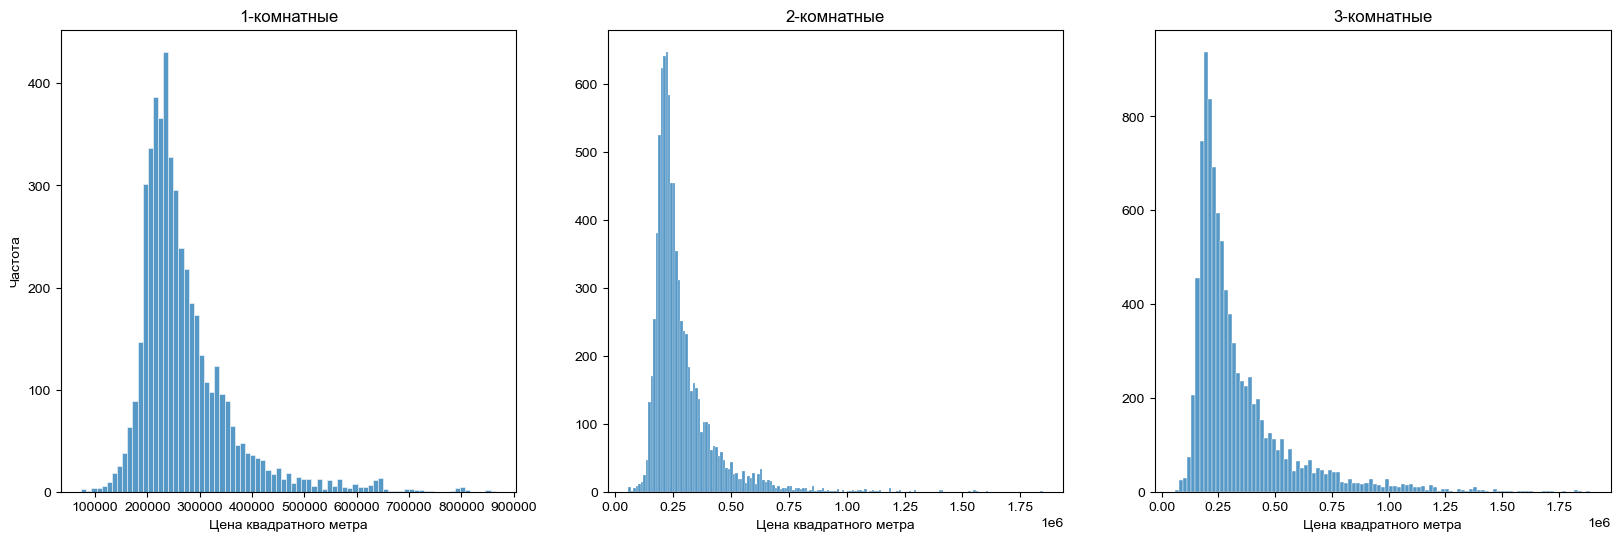

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))

sns.set(font_scale = 1)
sns.mpl.rc('figure', figsize = (20,10))
sns.histplot(list(data_market[data_market['rooms']==1][target]), ax=ax1).set(xlabel='Цена квадратного метра', ylabel='Частота', title = '1-комнатные')

sns.set(font_scale = 1)
sns.mpl.rc('figure', figsize = (20,10))
sns.histplot(list(data_market[data_market['rooms']==2][target]), ax=ax2).set(xlabel='Цена квадратного метра', ylabel='', title = '2-комнатные')

sns.set(font_scale = 1)
sns.mpl.rc('figure', figsize = (20,10))
sns.histplot(list(data_market[data_market['rooms']==3][target]), ax=ax3).set(xlabel='Цена квадратного метра', ylabel='', title = '3-комнатные')

plt.show()

Видно, что распределение таргета имеет очертания нормального распределения с тяжелым правым хвостом. По всей видимости имеется большое количество выбросов. Поэтому имеет смысл рассмотреть диаграмму размаха данной величины (опять в разрезе количества комнат). 

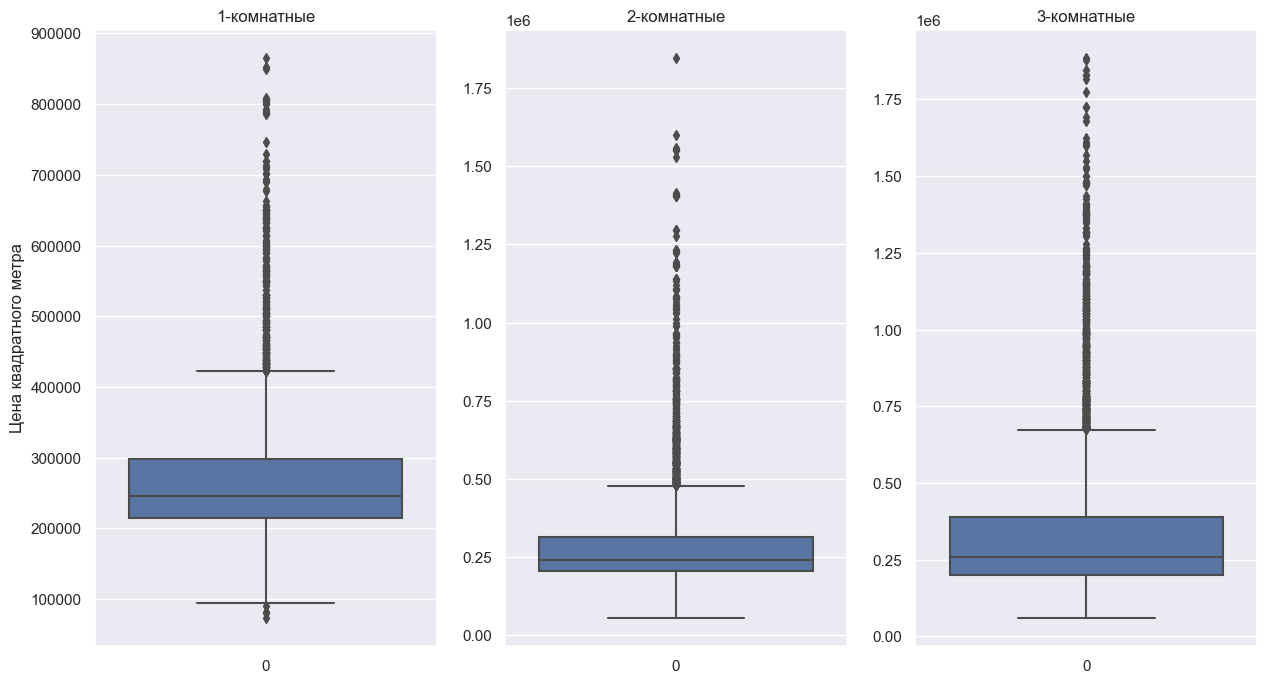

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,8))

sns.set(font_scale = 1)
sns.mpl.rc('figure')
sns.boxplot(data=list(data_market[data_market['rooms']==1][target]), ax=ax1).set(ylabel='Цена квадратного метра', title = '1-комнатные')

sns.set(font_scale = 1)
sns.mpl.rc('figure')
sns.boxplot(data=list(data_market[data_market['rooms']==2][target]), ax=ax2).set(ylabel='', title = '2-комнатные')

sns.set(font_scale = 1)
sns.mpl.rc('figure')
sns.boxplot(data=list(data_market[data_market['rooms']==3][target]), ax=ax3).set(ylabel='', title = '3-комнатные')

plt.show()

Видно, что по таргету имеется большое количество выбросов (при этом большая часть - очень большая стоимость квадратного метра). Однако визуально сложно определить масштаб проблемы. Посчитаем их.

In [8]:
_1, bp_1 = data_market[data_market['rooms'] == 1][target].plot.box(return_type='both')
plt.close()
_2, bp_2 = data_market[data_market['rooms'] == 2][target].plot.box(return_type='both')
plt.close()
_3, bp_3 = data_market[data_market['rooms'] == 3][target].plot.box(return_type='both')
plt.close()

outliers_1 = bp_1['fliers'][0].get_ydata()
outliers_2 = bp_2['fliers'][0].get_ydata()
outliers_3 = bp_3['fliers'][0].get_ydata()

k = 1
for i in [outliers_1, outliers_2, outliers_3]:
    print(f'Количество выбросов по {k}-комнатным квартирам: ' + str(len(i)))
    k = k + 1

Количество выбросов по 1-комнатным квартирам: 291
Количество выбросов по 2-комнатным квартирам: 608
Количество выбросов по 3-комнатным квартирам: 738


Если сравнивать количество выбросов с общим количеством квартир в выборке, то доля выбросов составляет примерно 5-7%. Это довольно большая величина. Это может указывать на пространственную неоднородность. Поэтому стоит посмотреть на таргет с точки зрения географии. 

###### Визуализация таргета на карте

Загруженная карта была получена через OpenStreetMap. Уровень детализации карты - муниципальные образования (соответствует admin_level=8). Для начала необходимо поработать с геометрией карты - убрать точки и оставить только полигоны и мультиполигоны. Для этого имеет смысл сначало перейти к проекции Меркатора, чтобы адекватно вычислить площади и отсеить точки (у них площадь равна 0). После чего необходимо наш DataFrame перевести в GeoDataFrame и задать географическую систему координат. После чего можно будет осуществить мэтчинг карты и наших данных по координатам (перед этим у карты осуществить обратный переход с проекции Меркатора на WGS84). Наконец можно будет вычислить среднюю цену за квадратный метр по географическим областям и визуализировать эту информацию на карте.

In [9]:
# Работа с картой
data_map = data_map.to_crs('epsg:32637') # Переходим к проекции Меркатора
data_map = data_map[data_map.area > 0] # Отсеиваем все точки по нулевой площади

In [10]:
# Работа с нашим DataFrame
data_geo = gpd.GeoDataFrame(data_market[target], geometry=
                            gpd.points_from_xy(data_market['lng'], data_market['lat'])) # Вносим геометрию в наши данные
data_geo.crs = 'epsg:4326' # Присваиваем географическую систему координат WGS84

In [11]:
# Мэтчинг карты и наших данных, расчет средних цен за квадратный метр по полигонам
data_map = data_map.to_crs('epsg:4326') # Обратный переход к от проекции Меркатора к WGS84

data_geo_map_full = gpd.sjoin(data_map, data_geo, predicate = 'contains', how = 'left')
data_geo_map = data_geo_map_full[['wikipedia', 'geometry', target]].copy()
data_geo_map = data_geo_map.dissolve(by = ['wikipedia'], aggfunc = 'mean')

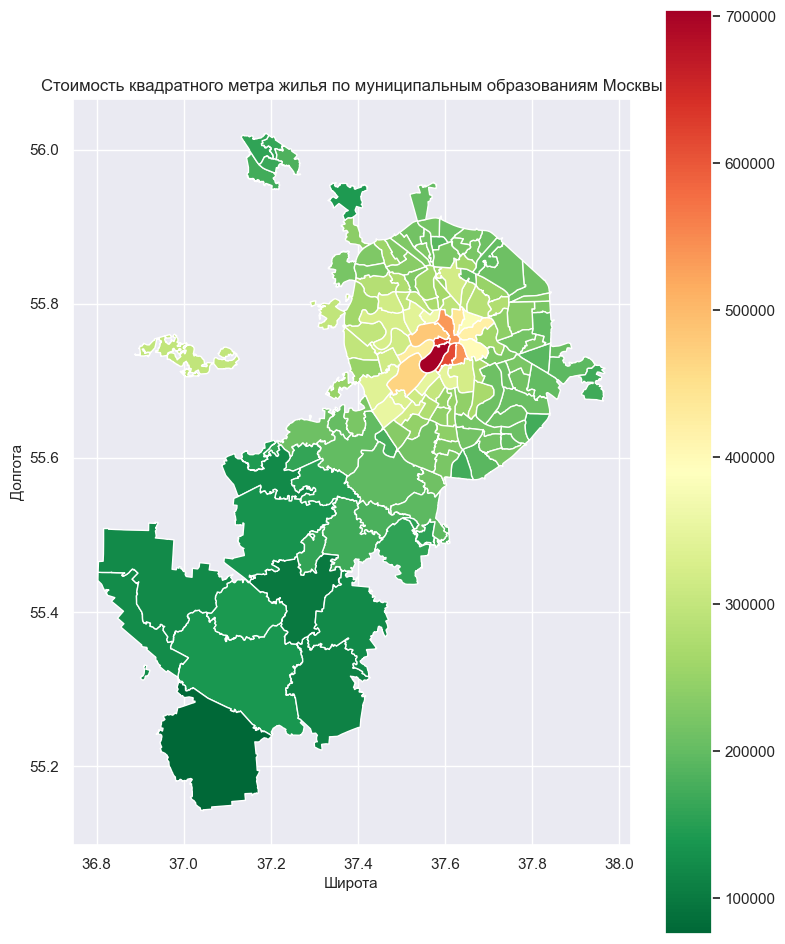

In [12]:
data_geo_map.plot(column=target, figsize = (9, 12), cmap = 'RdYlGn_r', legend = True)
plt.title('Стоимость квадратного метра жилья по муниципальным образованиям Москвы', fontsize = 12)
plt.xlabel('Широта', fontsize = 11)
plt.ylabel('Долгота', fontsize = 11)
plt.show()

Как видно по карте можно говорить о том, что рынок недвижимости Москвы разделяется на кластеры - имеются географические зоны с очень высокой стоимостью квадратного метра жилья и есть те зоны, где стоимость квдаратного метра относительно мала. При этом районы с дорогим жильем располагаются рядом друг с другом. То же самое действует и в отношении районов с относительно невысокой ценой квадратного метра жилья.

Таким образом наличие большого количества выбросов в данных связано с пространственной неоднородностью, которую нужно будет учитывать при разработке модели предсказания стоимости квадратного метра жилья. Вполне возможно, что признаки, не имеющих прямого отношения к пространству, смогут уловить эту пространственную неоднородность. Тем не менее обязательно следует проанализировать остатки модели на наличие пространственной автокорреляции (если она есть, то скорее всего положительная).

### Описательный анализ других полей

In [13]:
data_market[features_full].head()

,rooms,lat,lng,square_total,square_living,square_kitchen,ceiling,renovation,view,type_house,...,electrical_type,electrical_entries_count,heating_type,hot_water_type,gas_type,ventilation_type,firefighting_type,drainage_type,floor_flat,floor_house
0,1,55.602617,37.584514,32.1,18.7,6.7,2.64,Косметический,Во двор,Панельный,...,Центральное,2.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Приточно-вытяжная вентиляция,NaN,Внутренние водостоки,3.0,9.0
1,1,55.684777,37.669360,36.2,18.9,6.6,2.64,Косметический,На улицу,Панельный,...,Центральное,2.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Вытяжная вентиляция,Автоматическая,Внутренние водостоки,3.0,9.0
2,1,55.564806,37.498995,44.0,12.0,18.0,3.14,Без ремонта,Во двор,Монолитный,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,16.0
3,1,55.667213,37.513008,32.0,20.0,6.0,2.64,Евроремонт,Во двор,Панельный,...,Центральное,2.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Приточно-вытяжная вентиляция,Автоматическая,Внутренние водостоки,19.0,19.0
4,1,55.603781,37.655742,39.0,18.0,10.0,2.64,Без ремонта,NaN,Монолитно кирпичный,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,18.0


###### Пропуски в данных

Знакомство с остальными полями стоит начать с анализа пропусков в данных.

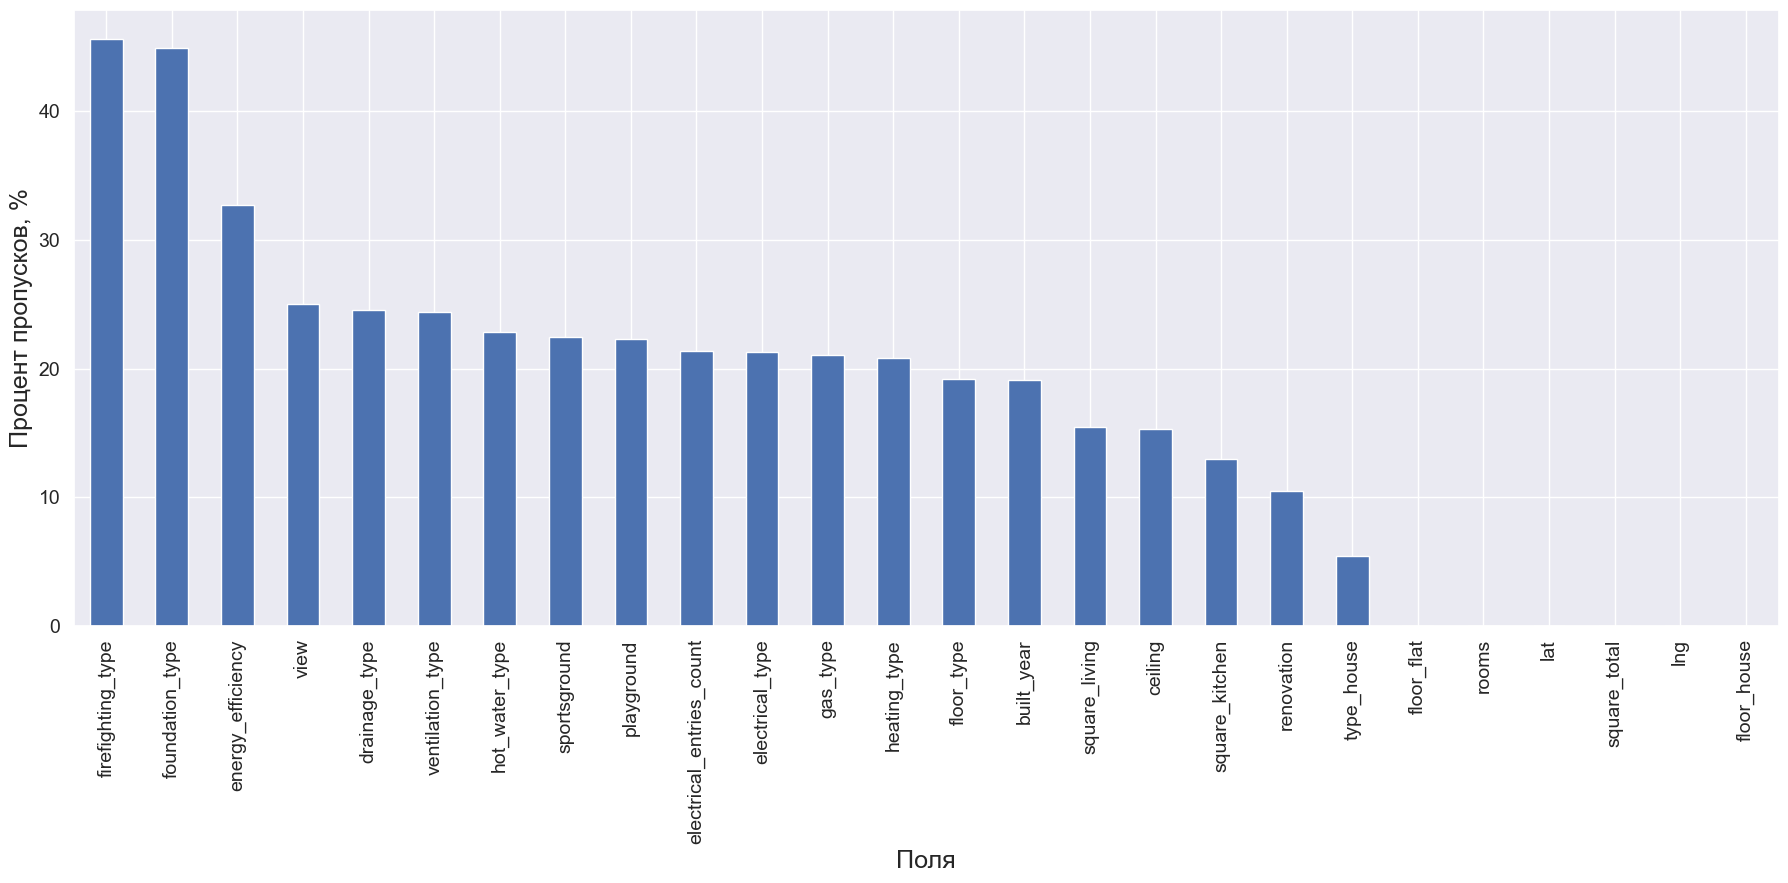

In [14]:
# Гистограмма пропусков
series = pd.isnull(data_market[features_full]).sum(axis=0)*100 / len(data_market[features_full])
series.sort_values(ascending=False).plot(kind='bar', fontsize = 14, figsize = (22,8))
plt.xlabel('Поля', fontsize = 18)
plt.ylabel('Процент пропусков, %', fontsize = 18)
plt.show()

Видно, что лидерами по количеству пропусков выступают тип системы пожаротушения (firefighting_type), тип фундамента (foundation_type) и класс энергетической эффективности (energy_efficiency) - доля пропусков по ним больше 30%. По остальным полям доля пропусков находится в диапазоне от 10 до 25%. 

Наличие пропусков в данных создает определенные сложности при использовании алгоритмов ML и эконометрических моделей. Приходится искать способы устранения данной проблемы (осуществлять заполнение пропусков различными способами и т. д.). Тем не менее, есть алгоритмы ML, которые их успешно обрабатывают без какой-то предварительно сложной подготовки (например, алгоритмы на деревьях решений).

###### Типы переменных и принимаемые значения

In [15]:
data_market[features_full].dtypes

rooms                         int64
lat                         float64
lng                         float64
square_total                float64
square_living               float64
square_kitchen              float64
ceiling                     float64
renovation                   object
view                         object
type_house                   object
floor_type                   object
built_year                  float64
energy_efficiency            object
playground                   object
sportsground                 object
foundation_type              object
electrical_type              object
electrical_entries_count    float64
heating_type                 object
hot_water_type               object
gas_type                     object
ventilation_type             object
firefighting_type            object
drainage_type                object
floor_flat                  float64
floor_house                 float64
dtype: object

В данном случае у нас имеются географические, непрерывные, дискретные и категориальные характеристики. Географические характеристики были задействованы ранее. Поэтому рассмотрим сразу непрерывные, к которым относятся square_total, square_living, square_kitchen, ceiling. Остальные поле, имеющие тип данных float64, дискретные по своей природе - в данном случае такой тип данных обусловлен технической стороной (наличие в колонке пропусков не позволяет записать в csv тип данных int).

In [16]:
data_market[['square_total', 'square_living', 'square_kitchen', 'ceiling']].describe()

,square_total,square_living,square_kitchen,ceiling
count,22932.000000,19377.000000,19951.000000,19415.000000
mean,68.050933,38.725293,11.166794,2.866965
std,31.029187,18.834541,5.860358,0.326607
min,12.000000,8.000000,2.500000,1.600000
25%,45.000000,26.000000,7.800000,2.640000
50%,60.200000,35.000000,10.000000,2.800000
75%,80.600000,47.000000,12.900000,3.000000
max,377.400000,350.000000,75.000000,7.000000


Как видно каких-то аномальных значений нет, поскольку вся предобработка по удалению выбросов, неадекватных значений и т. д. была сделана заранее. 

Далее рассмотрим дискретные характеристики - rooms, built_year, electrical_entries_count, floor_flat и floor_house.

In [17]:
data_market[['rooms', 'built_year', 'electrical_entries_count', 'floor_flat', 'floor_house']].describe()

,rooms,built_year,electrical_entries_count,floor_flat,floor_house
count,22932.000000,18549.000000,18023.000000,22932.000000,22932.000000
mean,2.201814,1985.587040,3.093936,7.813623,15.235086
std,0.766600,26.345835,4.723283,6.710409,9.274798
min,1.000000,1820.000000,0.000000,1.000000,1.000000
25%,2.000000,1966.000000,1.000000,3.000000,9.000000
50%,2.000000,1986.000000,2.000000,6.000000,14.000000
75%,3.000000,2009.000000,3.000000,11.000000,18.000000
max,3.000000,2020.000000,50.000000,56.000000,85.000000


Аномальных значений нет. Исключение составляет поле electrical_entries_count с максимальным значением 50. Однако для понимания адекватности данного значения требуются инженерные знания. Также имеет смысл проверить, есть ли строки, где этаж квартиры больше количества этажей в доме.

In [18]:
data_market[data_market['floor_flat']/data_market['floor_house'] > 1]

,price,rooms,lat,lng,square_total,square_living,square_kitchen,ceiling,renovation,view,...,electrical_entries_count,heating_type,hot_water_type,gas_type,ventilation_type,firefighting_type,drainage_type,floor_flat,floor_house,price/m2


Как видно такие наблюдения отсутствуют.

Наконец стоит проверить категориальные поля, к которым относятся все остальные.

In [19]:
data_market.select_dtypes(object).describe()

,renovation,view,type_house,floor_type,energy_efficiency,playground,sportsground,foundation_type,electrical_type,heating_type,hot_water_type,gas_type,ventilation_type,firefighting_type,drainage_type
count,20531,17201,21686,18538,15433,17824,17789,12634,18043,18152,17698,18096,17336,12475,17306
unique,4,3,5,2,10,2,2,5,2,5,5,3,3,3,3
top,Косметический,Во двор,Монолитный,Железобетонные,Не присвоен,Есть,Отсутствует,Ленточный,Центральное,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Отсутствует,Приточно-вытяжная вентиляция,Пожарные гидранты,Внутренние водостоки
freq,7615,9779,7578,18004,7662,11305,12020,6821,17879,16549,12291,10637,10944,6019,13128


В данном случае по каждому полю можно увидеть количество заполненных строк, количество уникальных значений, а также его самое распространнное значение и его частоту. Однако не понятно, какое распределение имеет та или иная категориальная фича, а также размеры самых малочисленных классов. Попробуем получить это информацию.

In [20]:
def values_cat_feat(data:pd.Series):
    data = data.dropna()
    dict_values = dict(zip(list(Counter(data).keys()), list(Counter(data).values())))
    [print(i + ':', dict_values[i]) for i in dict_values]

In [21]:
for i in data_market.select_dtypes(object).columns:
    print('\033[1m' + i + '\033[0m')
    values_cat_feat(data_market[i])
    print('_' * 100)

renovation
Косметический: 7615
Без ремонта: 3987
Евроремонт: 5681
Дизайнерский: 3248
____________________________________________________________________________________________________
view
Во двор: 9779
На улицу: 2703
На улицу и двор: 4719
____________________________________________________________________________________________________
type_house
Панельный: 6568
Монолитный: 7578
Монолитно кирпичный: 1102
Кирпичный: 4864
Блочный: 1574
____________________________________________________________________________________________________
floor_type
Железобетонные: 18004
Деревянные: 534
____________________________________________________________________________________________________
energy_efficiency
Не присвоен: 7662
D: 1377
B+: 1058
B: 1628
A++: 46
C: 1131
A: 941
A+: 126
E: 1280
B++: 184
____________________________________________________________________________________________________
playground
Есть: 11305
Отсутствует: 6519
_______________________________________________________

Видно, что практически по всем категориальным признакам малые классы отсутствуют за исключением energy_efficiency (класс A++) и heating_type (класс Квартирное отопление (квартирный котел)). Тем не менее было принято решение все же их оставить.

Также стоит отметить следующую особенность: все категориальные поля, за исключением energy_efficiency не импеют порядковую природу, поэтому и способ кодировки необходимо выбирать соответствующий. Однако energy_efficiency является порядковой переменной, следовательно следует иметь ввиду данный факт, чтобы при осуществлении кодировки не потерять эту информацию.  

### Выборки на train и out-of-sample

###### Разбиение исходной выборки на train и out-of-sample

После ознакомления с данными необходимо осуществить разбиение выборки на подвыборки train (обучающую) и out-of-sample (отложенная). Обучающая выборка будет использоваться для подбора оптимального преобразования фичей, обучение модели и подбор гиперпараметров и т. д. Отложенная выборка будет использоваться только в самом конце для проверки качества всех разработанных моделей и выбора наилучшей. Отложенная выборка необходима для того, чтобы избежать переобучения моделей.

Стоит отметить, что разбиение на выборки должно быть случайным. При этом необходимо получить такие выборки, которые были более менее похожи друг на друга. Для этого при разделении выборки осуществляется стратификация по тому или иному критерию. Например можно осуществить стратификацию с  контролем баланса количества комнат в квартире, или с контролем того, чтобы в обеих выборках было достаточно квартир из каждой географической зоны, или чтобы обе выборки были репрезентативными с точки зрения ценовых сегментов и т. д.

Поскольку в данном случае имеется ярко выраженная пространственная неоднородность, то имеет смысл осуществлять стратификацию относительно географических зон (то есть чтобы в каждой выборке от каждой географической зоны было достаточное количество квартир).

In [22]:
print('Размер исходного DataFrame: ' + str(data_market.shape))
print('Размер GeoDataFrame: ' + str(data_geo_map_full.shape))

Размер исходного DataFrame: (22932, 28)
Размер GeoDataFrame: (22933, 296)


Видно, что в GeoDataFrame есть лишняя строчка. Скорее всего она образовалась из-за технических особенностей мэтчинга и она заполнена None. В любом случае мы можем просто примэтчить колонку с названием географической зоны к исходному DataFrame и уже работать с нашими исходными данными. Мэтчинг в данном случае можно осуществить по индексам исходного DataFrame (у GeoDataFrame имеется колонка index_right, которая сохраняет в себе информацию об индексах исходного DataFrame, который мы примэтчили ранее).

In [23]:
data_geo_map_full[['wikipedia', 'index_right']].dropna().head()

,wikipedia,index_right
0,ru:Внуково (район Москвы),17414.0
0,ru:Внуково (район Москвы),21081.0
0,ru:Внуково (район Москвы),14375.0
0,ru:Внуково (район Москвы),5446.0
0,ru:Внуково (район Москвы),3734.0


In [24]:
data_geo_map_join = data_geo_map_full[['wikipedia', 'index_right']].dropna().copy()
data_geo_map_join = pd.DataFrame(data_geo_map_join)
data_geo_map_join.index = data_geo_map_join['index_right'].astype(int)
data_market = data_market.join(data_geo_map_join['wikipedia'], how = 'left')

Далее осуществляем деление выборки на train и out-of-sample со стратификацией по географическим зонам. Размеры train и out-of-sample выборок взяты как 75% и 25% соответственно от разбиваемой выборки.

In [25]:
train, out_of_sample = train_test_split(data_market, test_size=0.25, train_size=0.75, 
                                        shuffle=True, stratify=data_market['wikipedia'], random_state = 42)

train.reset_index(inplace = True, drop = True)
out_of_sample.reset_index(inplace = True, drop = True)

###### Описательные статистики выборок train и out-of-sample

Посмотрим, насколько репрезентативны выборки по отношению друг к другу. Для этого кратко посмотрим на их описательные статистики.

In [26]:
def table_stat(data_train, data_oos):
    data_train_oos = pd.DataFrame(columns = [data_train.name + '_train', data_oos.name + '_oos'])
    data_train_oos[data_train.name + '_train'] = data_train.describe()
    data_train_oos[data_train.name + '_oos'] = data_oos.describe()
    return data_train_oos

In [27]:
train_oos_describe_float = pd.DataFrame()
for i in ['square_total', 'square_living', 'square_kitchen', 'ceiling']:
    train_oos_describe_float = pd.concat([train_oos_describe_float, table_stat(train[i], out_of_sample[i])], axis = 1)

train_oos_describe_int = pd.DataFrame()
for i in ['rooms', 'built_year', 'electrical_entries_count', 'floor_flat', 'floor_house']:
    train_oos_describe_int = pd.concat([train_oos_describe_int, table_stat(train[i], out_of_sample[i])], axis = 1)

In [28]:
print('\033[1m' + 'Описательные ститистики полей float для train и out_of_sample: ' + '\033[0m')
train_oos_describe_float

Описательные ститистики полей float для train и out_of_sample: 


,square_total_train,square_total_oos,square_living_train,square_living_oos,square_kitchen_train,square_kitchen_oos,ceiling_train,ceiling_oos
count,17199.000000,5733.000000,14523.000000,4854.000000,14940.000000,5011.000000,14559.000000,4856.000000
mean,68.164036,67.711626,38.795419,38.515480,11.185114,11.112173,2.869150,2.860414
std,31.088341,30.851255,18.821634,18.873489,5.896594,5.751202,0.330007,0.316138
min,12.000000,12.700000,8.000000,9.000000,2.500000,3.000000,1.600000,1.700000
25%,45.000000,44.700000,26.500000,25.000000,7.800000,7.700000,2.640000,2.640000
50%,60.300000,60.000000,35.000000,34.300000,10.000000,10.000000,2.800000,2.800000
75%,80.900000,80.000000,47.000000,47.000000,12.925000,12.800000,3.000000,3.000000
max,377.400000,324.000000,350.000000,185.000000,75.000000,72.800000,7.000000,7.000000


In [29]:
print('\033[1m' + 'Описательные ститистики полей int для train и out_of_sample: ' + '\033[0m')
train_oos_describe_int

Описательные ститистики полей int для train и out_of_sample: 


,rooms_train,rooms_oos,built_year_train,built_year_oos,electrical_entries_count_train,electrical_entries_count_oos,floor_flat_train,floor_flat_oos,floor_house_train,floor_house_oos
count,17199.000000,5733.000000,13915.000000,4634.000000,13504.000000,4519.000000,17199.000000,5733.000000,17199.000000,5733.000000
mean,2.205651,2.190302,1985.550844,1985.695727,3.081013,3.132551,7.806442,7.835165,15.198674,15.344322
std,0.765491,0.769873,26.297778,26.492166,4.716940,4.742497,6.676659,6.811197,9.226763,9.417400
min,1.000000,1.000000,1820.000000,1870.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,1966.000000,1966.000000,1.000000,1.000000,3.000000,3.000000,9.000000,9.000000
50%,2.000000,2.000000,1986.000000,1987.000000,2.000000,2.000000,6.000000,6.000000,14.000000,14.000000
75%,3.000000,3.000000,2009.000000,2009.000000,3.000000,3.000000,10.000000,11.000000,18.000000,18.000000
max,3.000000,3.000000,2020.000000,2020.000000,50.000000,50.000000,56.000000,56.000000,85.000000,65.000000


Видно, что для числовых признаков описательные ститистики примерно одинаковые. Осталось посмотреть на категориальные признаки. Важно, чтобы по каждому такому признаку все его значения (даже малочисленные) присутствовали в обеих выборках.

In [30]:
train_oos_describe_cat = pd.DataFrame(columns = ['cat_feat', 'unique_values_train', 'unique_values_oos'])

k = 0
for i in data_market.select_dtypes(object).columns:
    train_oos_describe_cat.loc[k, 'cat_feat'] = i
    train_oos_describe_cat.loc[k, 'unique_values_train'] = len(train[i].dropna().unique())
    train_oos_describe_cat.loc[k, 'unique_values_oos'] = len(out_of_sample[i].dropna().unique())
    k = k + 1

In [31]:
train_oos_describe_cat

,cat_feat,unique_values_train,unique_values_oos
0,renovation,4,4
1,view,3,3
2,type_house,5,5
3,floor_type,2,2
4,energy_efficiency,10,10
5,playground,2,2
6,sportsground,2,2
7,foundation_type,5,5
8,electrical_type,2,2
9,heating_type,5,5


Видно, что все значения категориальных фичей представлены в обеих выборках.

###### Пропуски в выборках train и out-of-sample

Наконец стоит проверить то, насколько выборки репрезентативны с точки зрения количества пропусков.

In [32]:
series_train_na = pd.isnull(train[features_full]).sum(axis=0)*100 / len(train[features_full])
series_oos_na = pd.isnull(out_of_sample[features_full]).sum(axis=0)*100 / len(out_of_sample[features_full])
data_train_oos_na = pd.concat([series_train_na, series_oos_na], axis = 1)
data_train_oos_na.columns = ['train','oos']

In [33]:
data_train_oos_na

,train,oos
rooms,0.000000,0.000000
lat,0.000000,0.000000
lng,0.000000,0.000000
square_total,0.000000,0.000000
square_living,15.559044,15.332287
square_kitchen,13.134485,12.593755
ceiling,15.349730,15.297401
renovation,10.669225,9.872667
view,24.815396,25.518926
type_house,5.273562,5.913134


Таким образом разбитые выборки train и out-of-sample репрезентативны по отношению друг к другу. Следовательно, разбиение оказалось успешным.

###### Сохранение выборок train и out-of-sample

In [34]:
train.reset_index(inplace = True, drop = True)
out_of_sample.reset_index(inplace = True, drop = True)

train.to_csv(PATH_DATA + 'data_december_2021_train.csv', index = False)
out_of_sample.to_csv(PATH_DATA + 'data_december_2021_oos.csv', index = False)